# RSoXS API Prototype

This notebook demonstrates the new high-level interface for beamline control with:

- DataFrame-based scan definitions
- Automatic uncertainty propagation with `ufloat`
- Safe async patterns (context managers, abort mechanism)
- Proper error handling


In [1]:
import sys
import asyncio
import numpy as np
import pandas as pd
from pathlib import Path

# Import our new API
from api_dev.types import ScanPoint, ScanResult
from api_dev.validation import find_exposure_column, validate_scan_dataframe
from api_dev.scan import ScanPlan, ScanExecutor
from bcs import BCSz

## Test 1: Validation Functions

Let's test the DataFrame validation with different column naming conventions.


In [2]:
# Test exposure column detection
test_dfs = [
    pd.DataFrame({"Sample X": [1, 2], "exposure": [1.0, 1.5]}),
    pd.DataFrame({"Sample X": [1, 2], "exp": [1.0, 1.5]}),
    pd.DataFrame({"Sample X": [1, 2], "count_time": [1.0, 1.5]}),
    pd.DataFrame({"Sample X": [1, 2], "Unnamed: 2": [1.0, 1.5]}),
    pd.DataFrame({"Sample X": [1, 2], "": [1.0, 1.5]}),
]

for i, df in enumerate(test_dfs):
    col = find_exposure_column(df)
    print(f"Test {i + 1}: Detected exposure column: '{col}'")

Test 1: Detected exposure column: 'exposure'
Test 2: Detected exposure column: 'exp'
Test 3: Detected exposure column: 'count_time'
Test 4: Detected exposure column: 'Unnamed: 2'
Test 5: Detected exposure column: ''


In [4]:
# Test full DataFrame validation
scan_df = pd.DataFrame(
    {
        "Sample X": [10.0, 10.5, 11.0],
        "Sample Y": [0.0, 0.0, 0.0],
        "exposure": [1.0, 1.5, 2.0],
    }
)

motor_cols, exposure_col = validate_scan_dataframe(scan_df)
print(f"Motor columns: {motor_cols}")
print(f"Exposure column: {exposure_col}")

Motor columns: ['Sample X', 'Sample Y']
Exposure column: exposure


## Test 2: ScanPlan Creation

Build a validated scan plan from DataFrame.


In [4]:
# Create scan plan
scan_plan = ScanPlan.from_dataframe(
    df=scan_df,
    ai_channels=["Photodiode", "TEY signal"],
    default_delay=0.2,
    shutter="Light Output",
)

print(f"Scan plan created with {len(scan_plan)} points")
print(f"Motor columns: {scan_plan.motor_names}")
print(f"AI channels: {scan_plan.ai_channels}")
print(f"\nFirst scan point:")
print(f"  Index: {scan_plan.points[0].index}")
print(f"  Motors: {scan_plan.points[0].motors}")
print(f"  Exposure: {scan_plan.points[0].exposure_time}s")

Scan plan created with 3 points
Motor columns: ['Sample X', 'Sample Y']
AI channels: ['Photodiode', 'TEY signal']

First scan point:
  Index: 0
  Motors: {'Sample X': 10.0, 'Sample Y': 0.0}
  Exposure: 1.0s


## Test 3: Connect to Beamline

Connect to the RSoXS beamline server.


In [5]:
# Connect to server
rsoxs = BCSz.BCSServer()
await rsoxs.connect(addr="localhost", port=5577)
print("✓ Connected to beamline server")

Server Public Key b'!.(eW{0znDh:w*:dx5l@2*4Cy0i#7ddX[}Z)ho:B'
✓ Connected to beamline server


## Test 4: Execute Simple Scan

Run a small scan using the new interface.


In [7]:
# Create a simple scan
simple_scan_df = pd.DataFrame(
    {"Sample Y": np.linspace(10, 12, 5), "exposure": [1.0] * 5}
)

# Build scan plan
simple_plan = ScanPlan.from_dataframe(
    df=simple_scan_df,
    ai_channels=["Photodiode", "TEY signal", "AI 3 Izero"],
    default_delay=0.2,
    shutter="Light Output",
)

# Create executor
executor = ScanExecutor(rsoxs)

# Execute scan
print("Starting scan...")
results = await executor.execute_scan(simple_plan, progress=True)

print(f"\n✓ Scan complete! Collected {len(results)} points")
print(f"\nResults preview:")
print(results.head())

Starting scan...


Scanning: 100%|██████████| 5/5 [00:17<00:00,  3.52s/pt]


✓ Scan complete! Collected 5 points

Results preview:
   Sample Y_position  Photodiode_mean  Photodiode_std  TEY signal_mean  \
0               10.0         9.318993        0.063443        -0.001721   
1               10.5         9.294121        0.064215        -0.001727   
2               11.0         9.330463        0.063077        -0.001694   
3               11.5         9.330269        0.063084        -0.001705   
4               12.0         9.292230        0.064275        -0.001708   

   TEY signal_std  AI 3 Izero_mean  AI 3 Izero_std  exposure     timestamp  
0        0.000018        -0.017628        0.000158       1.0  1.762741e+09  
1        0.000017        -0.017625        0.000170       1.0  1.762741e+09  
2        0.000017        -0.017542        0.000159       1.0  1.762741e+09  
3        0.000016        -0.017581        0.000163       1.0  1.762741e+09  
4        0.000017        -0.017775        0.000161       1.0  1.762741e+09  


## Test 5: Analyze Results with Uncertainty

The results automatically have mean and std columns for error propagation.


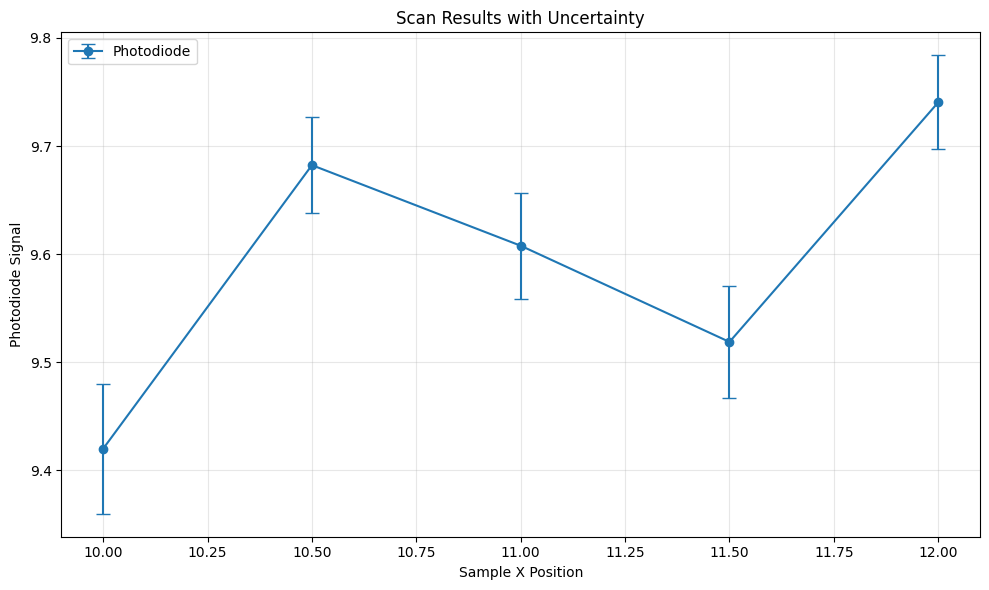

In [7]:
import matplotlib.pyplot as plt

# Plot photodiode with error bars
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(
    results["Sample X_position"],
    results["Photodiode_mean"],
    yerr=results["Photodiode_std"],
    marker="o",
    capsize=5,
    label="Photodiode",
)

ax.set_xlabel("Sample X Position")
ax.set_ylabel("Photodiode Signal")
ax.set_title("Scan Results with Uncertainty")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Test 6: Calculate Transmission with Error Propagation

Use `uncertainties` package to propagate errors through calculations.


In [ ]:
from uncertainties import unumpy as unp

# Reconstruct ufloat arrays
photodiode = unp.uarray(results["Photodiode_mean"], results["Photodiode_std"])

izero = unp.uarray(results["AI 3 Izero_mean"], results["AI 3 Izero_std"])

# Calculate transmission with automatic error propagation
transmission = photodiode / izero

# Extract mean and uncertainty
results["transmission_mean"] = unp.nominal_values(transmission)
results["transmission_std"] = unp.std_devs(transmission) / np.sqrt(len(transmission))

print("Transmission with uncertainty:")
print(results[["Sample X_position", "transmission_mean", "transmission_std"]])

Transmission with uncertainty:
    Sample X_position  transmission_mean  transmission_std
0           10.000000        -477.625951          1.300401
1           10.204082        -502.454446          1.125257
2           10.408163        -500.228741          1.122753
3           10.612245        -511.861090          1.099242
4           10.816327        -509.021670          1.121011
5           11.020408        -493.499432          1.108868
6           11.224490        -500.725701          1.155370
7           11.428571        -497.277507          1.182963
8           11.632653        -491.356618          1.155555
9           11.836735        -500.031920          1.170971
10          12.040816        -503.442229          1.115736
11          12.244898        -498.316011          1.128991
12          12.448980        -533.251011          1.127471
13          12.653061        -499.173669          1.182616
14          12.857143        -480.831989          1.186330
15          13.061224    

## Test 7: Abort Mechanism

Demonstrate scan abort functionality. There are two ways to abort:

**Option 1: Use Jupyter's Interrupt Kernel** (Recommended)

- Click the ⏹️ stop button in the toolbar, or
- Press `Ctrl+C` in the terminal, or
- Use Kernel → Interrupt menu

**Option 2: Use asyncio.CancelledError** (Programmatic)

- This is shown in the cells below for programmatic control


In [13]:
# Option 1: Simple await (use Jupyter's interrupt button to stop)
long_scan_df = pd.DataFrame(
    {"Sample X": np.linspace(10, 20, 50), "exposure": [0.5] * 50}
)

long_plan = ScanPlan.from_dataframe(long_scan_df)

print("Starting long scan (50 points)...")
print("Press the ⏹️ button or use Kernel → Interrupt to abort!")

try:
    results = await executor.execute_scan(long_plan, progress=True)
    print(f"✓ Scan completed: {len(results)} points")
except asyncio.CancelledError:
    print("⚠ Scan was interrupted!")
    raise  # Re-raise to properly clean up

Starting long scan (50 points)...
Press the ⏹️ button or use Kernel → Interrupt to abort!


Scanning:  20%|██        | 10/50 [00:10<00:40,  1.01s/pt]


⚠ Scan was interrupted!


CancelledError: 

In [ ]:
# Option 2: Programmatic abort using background task
# This approach lets you abort from another cell

long_scan_df = pd.DataFrame(
    {"Sample X": np.linspace(10, 20, 50), "exposure": [0.5] * 50}
)

long_plan = ScanPlan.from_dataframe(long_scan_df)

# Create a background task without awaiting it
scan_task = asyncio.create_task(executor.execute_scan(long_plan, progress=True))

print("Starting long scan (50 points)...")
print("Run the NEXT cell to abort programmatically!")
print(f"Task status: {scan_task}")

# Note: This cell will complete immediately, allowing you to run the next cell

⚠ Abort signal sent!


In [ ]:
# Abort the background scan
await executor.abort()
print("⚠ Abort signal sent!")

# Wait for the task to finish (it should raise ScanAbortedError)
try:
    results = await scan_task
    print(f"Scan completed: {len(results)} points")
except Exception as e:
    print(f"✓ Scan aborted: {type(e).__name__}: {e}")

In [ ]:
# Option 3: Use asyncio.wait_for with timeout (auto-abort after N seconds)
long_scan_df = pd.DataFrame(
    {"Sample X": np.linspace(10, 20, 50), "exposure": [0.5] * 50}
)

long_plan = ScanPlan.from_dataframe(long_scan_df)

print("Starting long scan with 5-second timeout...")

try:
    results = await asyncio.wait_for(
        executor.execute_scan(long_plan, progress=True),
        timeout=5.0,  # Auto-abort after 5 seconds
    )
    print(f"✓ Scan completed: {len(results)} points")
except asyncio.TimeoutError:
    print("⚠ Scan timed out and was aborted!")
except Exception as e:
    print(f"⚠ Scan error: {type(e).__name__}: {e}")

## Test 8: Multi-Motor Scan

Define a scan with multiple motors moving simultaneously.


In [ ]:
# Create 2D grid scan
x_positions = np.linspace(10, 12, 3)
y_positions = np.linspace(0, 2, 3)

# Create meshgrid
X, Y = np.meshgrid(x_positions, y_positions)

# Flatten into DataFrame
multi_motor_df = pd.DataFrame(
    {
        "Sample X": X.flatten(),
        "Sample Y": Y.flatten(),
        "exposure": [1.0] * len(X.flatten()),
    }
)

print("Multi-motor scan plan:")
print(multi_motor_df)

# Execute scan
multi_plan = ScanPlan.from_dataframe(
    multi_motor_df, ai_channels=["Photodiode"], default_delay=0.2
)

print(f"\n✓ Created scan plan with {len(multi_plan)} points")
print("Ready to execute...")

## Summary

This prototype demonstrates:

1. ✅ **DataFrame Validation** - Smart column detection for exposure times
2. ✅ **Type Safety** - Motor names validated against type literals
3. ✅ **Uncertainty Propagation** - ufloat values with automatic error propagation
4. ✅ **Async Safety** - Context managers ensure cleanup
5. ✅ **Abort Mechanism** - Scans can be cancelled from Jupyter
6. ✅ **Multi-Motor Support** - Multiple motors move simultaneously
7. ✅ **Progress Tracking** - Visual feedback during scans

### Next Steps

1. Add full RsoxsServer integration
2. Implement NEXAFS-specific calculations
3. Add comprehensive error handling
4. Write unit tests
5. Create tutorial notebooks
